In [0]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from collections import Counter
pd.set_option('display.max_columns', None)

In [13]:
data = pd.read_csv('hr.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (48,52,55,56,57,59,60,61,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning & Feature Engineering

### remove redundant columns and perform type conversion, encoding etc.

In [0]:
text_cols = ['EDUCATION_LEVEL','COUNTRY_OF_CITIZENSHIP','HOME_CITY','VISA','JOB_GRADE','JOB_TITLE','Manager_Edu_Level'\
             ,'EDUCATION_LEVEL_YEAR','Manager_Edu_Level_Year','REPORTS_TO_PENN_ID']
for col in text_cols:
    data[col] = data[col].fillna('')
    data[col] = data[col].apply(str).str.strip()
    
edu_cols = ['EDUCATION_LEVEL_YEAR','Manager_Edu_Level_Year']
for col in edu_cols:
    data[col] = data[col].apply(lambda x: int(x) if len(x)>0 else None)

In [0]:
# transform str to datetime object
dates_cols = ['Birth_Date','PRIMARY_APPT_BEGIN_DATE','ORIGINAL_HIRE_DATE','TERMINATION_DATE']
for col in dates_cols:
    data[col] = pd.DatetimeIndex(data[col])

#### Make new age columns
Age/Time related columns
'Birth_Date', 'AGE_AT_TERMINATION', 'CURRENT_AGE', 'PRIMARY_APPT_BEGIN_DATE', 'MONTHS_IN_PRIMARY_JOB', 
'ORIGINAL_HIRE_DATE', 'TERMINATION_DATE'<br>

1.Age_start: age when started to work at Penn: ORIGINAL_HIRE_DATE - Birth_Date <br>
2.Age_last: AGE_AT_TERMINATION or CURRENT_AGE if active <br>
3.MONTHS_IN_PRIMARY_JOB<br>

Remove other Age/Time related columns other than the three above. <br>

In [0]:
data['Age_start'] = data['ORIGINAL_HIRE_DATE'] - data['Birth_Date']
data['Age_start'] = data['Age_start'].apply(lambda x: int(np.floor(x.days/365)))
data['Age_last'] = data['AGE_AT_TERMINATION'].fillna(data['CURRENT_AGE'])

#### Is_First

In [0]:
# 1 indicates the primary job is the employee's first job at Penn, 0 indicates otherwise
data['Is_First'] = (data['ORIGINAL_HIRE_DATE'] == data['PRIMARY_APPT_BEGIN_DATE']).astype(int)

data = data.drop(columns = ['Birth_Date', 'AGE_AT_TERMINATION', 'CURRENT_AGE', 'PRIMARY_APPT_BEGIN_DATE',\
                            'ORIGINAL_HIRE_DATE', 'TERMINATION_DATE'])

### Local, US

In [0]:
# replace "PHILA" with PHILADELPHIA. 
data['HOME_CITY'] = data['HOME_CITY'].apply(lambda x: 'PHILADELPHIA' if x == 'PHILA' else x)
data['Local'] = data['HOME_CITY'].apply(lambda x: 1 if x == 'PHILADELPHIA' else 0)
data['US'] = data['COUNTRY_OF_CITIZENSHIP'].apply(lambda x: 1 if x == '' else 0)

data = data.drop(columns = ['COUNTRY_OF_CITIZENSHIP','HOME_CITY'])

### average ratings

In [0]:
rating_map = {'E':10,'R':8,'M':6,'N':4,'U':2}
rating_df = pd.DataFrame()
for year in range(2010,2020):
    data['OVR_RATING_CD_'+str(year)] = data['OVR_RATING_CD_'+str(year)].apply(lambda x: rating_map[x] if x in rating_map else 0)
    rating_df = pd.concat([rating_df,data['OVR_RATING_CD_'+str(year)]],axis=1)
    data = data.drop(columns = ['OVR_RATING_DESCR_'+str(year),'OVR_RATING_CD_'+str(year)])

valid_years = np.array([10-c[0] for c in [Counter(x) for x in rating_df.values]])
total = np.array(rating_df.apply(np.sum,axis=1).values)
avg_rating = np.zeros(len(total))
for i in range(len(total)):
    if valid_years[i] == 0:
        avg_rating[i] = None
    else:
        avg_rating[i] = total[i]/valid_years[i]
data['avg_rating'] = pd.Series(avg_rating)

### model manager data as the difference between manager and employee

### encoding the following text columns into numerical values

In [0]:
# Has_Manager indicates if a person has a manager (1)
data['Has_Manager'] = data['REPORTS_TO_PENN_ID'].apply(lambda x: 0 if len(x)==0 else 1)

# 1 if manager and employee are of different sex
data['sex_diff'] = (data["SEX"]!=data['Manager_Sex']).apply(int)
data.loc[data['Manager_Sex'].isnull(),'sex_diff'] = 0

# 1 if manager and employee are of different race
data['race_diff'] = (data["RACE"]!=data['Manager_Race']).apply(int)
data.loc[data['Manager_Race'].isnull(),'race_diff'] = 0

data = data.drop(columns = ['Manager_Race','Manager_Sex'])

#### Education level 

In [0]:
edu_map = {'B':0, 'C':1,'E':2, 'D':2, 'F':3, 'G':4, 'H':5, 'K':6,'I':6, 'L':6, 'J':6}

# map NaN in education level to 1, same group as "C"
data['EDUCATION_LEVEL'] = data['EDUCATION_LEVEL'].apply(lambda x: edu_map[x] if x in edu_map else 1)

# leave NaN in nanager education as None
data['Manager_Edu_Level'] = data['Manager_Edu_Level'].apply(lambda x: edu_map[x] if x in edu_map else None)

# difference between manager and employee education levels
# if someone doesn't have a manager, or manager education data is missing make the difference 0
data['edu_diff'] = data['Manager_Edu_Level'] - data['EDUCATION_LEVEL']
data['edu_diff'] = data['edu_diff'].fillna(0)

# remove EDUCATION_LEVEL_YEAR for now, 5000 missing values
data = data.drop(columns=['EDUCATION_LEVEL_YEAR','Manager_Edu_Level'])

In [0]:
data['PAY_CYCLE'] = data['PAY_CYCLE'].apply(lambda x: 0 if x == 'M1' else 1)
data['SEX'] = data['SEX'].apply(lambda x: 0 if x == 'M' else 1)

categorical_cols = ['RACE','MARITAL_STATUS','GRANT_PAID']
for col in categorical_cols:
    df = pd.get_dummies(data[col]).rename(lambda x: col+'_'+str(x), axis=1)
    data = pd.concat([data, df], axis=1)
    data = data.drop(columns = col)

#### job grade

Remove job grade = 'PHR'<br>
Job grade A-H are IT positions and correspond to job grade 25-32 respectively <br>
Job grade U indicates in union: mostly maintenance people judging from their job titles, classify them as job grade 21(lowest in dataset) <br>
Add new column IS_IT <br>  


In [0]:
job_grade = {}

# create a dict that maps A-H to 25-32
for i,j in enumerate(range(25,33)):
    job_grade[chr(ord('A')+i)] = j
    
# new column IS_IT, 1 for yes, 0 for no
x = data['JOB_GRADE'].apply(lambda x: 1 if x in job_grade else 0)
x = x.to_frame().rename(columns={'JOB_GRADE':'IS_IT'})
data = pd.concat([data, x], axis=1)

# convert letter job grades to numbers
job_grade['U'] = 21
data['JOB_GRADE'] = data['JOB_GRADE'].apply(lambda x: job_grade[x] if x in job_grade else x)

# Remove job grade = 'PHR'
data = data[data['JOB_GRADE']!='PHR']

data['JOB_GRADE'] = data['JOB_GRADE'].astype(int)

In [0]:
redundant_cols = ['Race_Desc','Sex_Desc','EDUCATION_LEVEL_DESC','HOME_ZIP','YEARS_IN_PRIMARY_JOB','YEARS_OF_SERVICE',
                  'EMPLOYMENT_STATUS_DESC',
                  'Dept_Name','Dept_Name_Short',
                  'School_Name','School_Abbrev',
                  'PRIMARY_APPT_JOB_CLASS',
                  'Job_Grade_Fiscal_Year','AnnualMinimum',
                  'AnnualFirstThird','AnnualMidPoint','AnnualSecondThird','AnnualMax',
                  'REPORTS_TO_PENN_ID',
                  'REPORTS_TO_DATE',
                  'Manager_Years_Managed',
                  'Manager_Original_Hire_Date',
                  'Manager_Edu_Level_Desc','Manager_Sex_Desc','Manager_Race_Desc','Termination_Fiscal_Year',
                  'SEPERATION_REASON_DESC',
                  'Retirement_Eligible_Date']

data = data.drop(columns = redundant_cols)

#### remove rating and some manager data

In [0]:
data = data.drop(columns = ['Manager_Months_Managed','Manager_Current_Age','Manager_Age_At_Termination',\
                            'Manager_Edu_Level_Year','Manager_YEARS_OF_SERVICE','Manager_OfColor','Manager_Job_Title'])
data = data.drop(columns = 'avg_rating')

####  remove home department data

In [0]:
data = data.drop(columns = ['HOME_DEPT_ORG', 'HOME_SCHOOL_CTR'])

####  Remove Race_OfColor, JOB_TITLE, jobs_active and SEPARATION_REASON

In [0]:
# remove entries whose separation reason is death or retirement
data = data[(data['SEPARATION_REASON'] !='80') & (data['SEPARATION_REASON'] !='30') \
            &(data['SEPARATION_REASON'] !='33') & (data['SEPARATION_REASON'] !='81')]

In [0]:
data = data.drop(columns = ['Race_OfColor','JOB_TITLE', 'SEPARATION_REASON','JOBS_ACTIVE'])

#### TO DO: 
1.partition by home school ctr <br>
2.Fiscal Year is ignored here <br>
3.add column: if visa terminates within a year of terminatino date/in two years if active

In [0]:
data['VISA_EXPIRATION_DATE'] = pd.DatetimeIndex(data['VISA_EXPIRATION_DATE'])
data = data.drop(columns = ['VISA','VISA_EXPIRATION_DATE'])

In [30]:
data.head()

,Worker_ID,SEX,EDUCATION_LEVEL,MONTHS_IN_PRIMARY_JOB,PRIMARY_APPT_SALARY,JOB_GRADE,IN_UNION,PAY_CYCLE,Starting_Full_Time_Salary,Career_Salary_Growth,Percent_Career_Salary_Growth,Number_of_Sal_Adjustments,Number_of_Reclass,EMPLOYMENT_STATUS,VOLUNTARY,Age_start,Age_last,Is_First,Local,US,Has_Manager,sex_diff,race_diff,edu_diff,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,MARITAL_STATUS_D,MARITAL_STATUS_M,MARITAL_STATUS_S,MARITAL_STATUS_W,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,IS_IT
0,1,0,1,32,41615.00,25,0,1,40000.0,1615.00,0.0403,0,0,T,0.0,26,28.0,1,0,1,1,0,0,4.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,2,0,4,10,32714.00,25,0,0,26000.0,6714.00,0.2582,0,0,T,1.0,23,27.0,0,1,1,1,0,0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,0,4,84,62636.72,26,0,0,52000.0,10636.72,0.2045,0,0,T,0.0,39,46.0,1,1,1,1,1,0,2.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1
4,5,1,1,4,29120.00,24,0,0,29120.0,0.00,0.0000,0,0,T,1.0,21,23.0,0,1,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
5,6,0,1,26,27895.49,24,0,0,27000.0,895.49,0.0331,0,0,T,1.0,23,25.0,1,0,1,1,0,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


## Training Data Selection

##### remove rows where Starting_Full_Time_Salary is null, remove the column because it is linearly correlated with PRIMARY_APPT_SALARY and Career_Salary_Growth

In [0]:
data = data[data['Starting_Full_Time_Salary'].notnull()]
data = data.drop(columns='Starting_Full_Time_Salary')

### Data selection and partition criteria
1.we would like to partition people into two classes: who stayed more than T (active or terminated) and people who stayed less than T (only terminated) <br> 
2.two classes shouldn't be skewed

In [0]:
data = data[data['MONTHS_IN_PRIMARY_JOB']>=0]

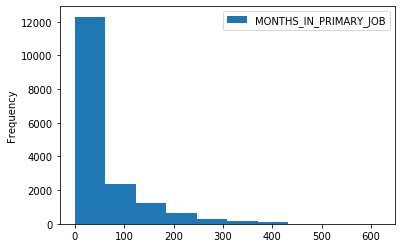

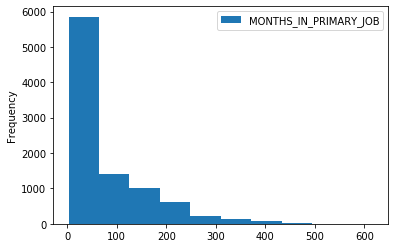

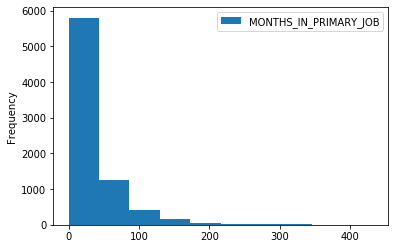

In [33]:
hist = data[['MONTHS_IN_PRIMARY_JOB']].plot.hist(bins=10)

hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']!='T'].plot.hist(bins=10) 

hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']=='T'].plot.hist(bins=10)

terminated within 0.0-1.0 years (<= 11.0 months): 0.2511621900826446, percentage_sum: 0.2511621900826446
terminated within 1.0-2.0 years (<= 23.0 months): 0.2550361570247934, percentage_sum: 0.506198347107438
terminated within 2.0-3.0 years (<= 35.0 months): 0.1716167355371901, percentage_sum: 0.6778150826446281
terminated within 3.0-4.0 years (<= 47.0 months): 0.09839876033057851, percentage_sum: 0.7762138429752066
terminated within 4.0-5.0 years (<= 59.0 months): 0.06159607438016529, percentage_sum: 0.8378099173553719
terminated within 5.0-6.0 years (<= 71.0 months): 0.03848140495867768, percentage_sum: 0.8762913223140496
terminated within 6.0-7.0 years (<= 83.0 months): 0.026472107438016527, percentage_sum: 0.9027634297520661
terminated within 7.0-8.0 years (<= 95.0 months): 0.022985537190082644, percentage_sum: 0.9257489669421488
terminated within 8.0-9.0 years (<= 107.0 months): 0.016141528925619833, percentage_sum: 0.9418904958677686
terminated within 9.0-10.0 years (<= 119.0 mon

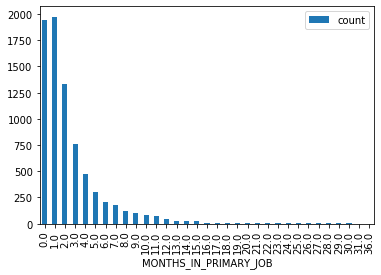

In [34]:
x = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']=='T'].\
    groupby(by = np.floor(data['MONTHS_IN_PRIMARY_JOB']/12)).\
    count().rename(columns={'MONTHS_IN_PRIMARY_JOB':'count'})

ax = x.plot.bar(y='count')
 
for c,i in enumerate(x.index):
    per_year = x.iloc[c:(c+1)].values.sum()/x.values.sum()
    percentage = x.iloc[:(c+1)].values.sum()/x.values.sum()
    print('terminated within {}-{} years (<= {} months): {}'.format(i,i+1,12*(i+1)-1,per_year), 'percentage_sum: {}'.format(percentage),sep=', ')
    if percentage>=0.95:
        break

In [35]:
label0 = data[['Worker_ID']][data['EMPLOYMENT_STATUS'] == 'A']                    
label1 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)]

data = data.drop(columns = ['EMPLOYMENT_STATUS','VOLUNTARY']) 

print(label0.shape, label1.shape, data.shape,sep=' ')

label0['label'] = 0
label1['label'] = 1
label = pd.concat([label0,label1],axis=0)

(9376, 1) (6528, 1) (17133, 37)


In [0]:
data = data.merge(label, how='right')
data.set_index('Worker_ID',inplace=True)

In [37]:
data.head()

,SEX,EDUCATION_LEVEL,MONTHS_IN_PRIMARY_JOB,PRIMARY_APPT_SALARY,JOB_GRADE,IN_UNION,PAY_CYCLE,Career_Salary_Growth,Percent_Career_Salary_Growth,Number_of_Sal_Adjustments,Number_of_Reclass,Age_start,Age_last,Is_First,Local,US,Has_Manager,sex_diff,race_diff,edu_diff,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,MARITAL_STATUS_D,MARITAL_STATUS_M,MARITAL_STATUS_S,MARITAL_STATUS_W,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,IS_IT,label
Worker_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,4,10,32714.00,25,0,0,6714.00,0.2582,0,0,23,27.0,0,1,1,1,0,0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
5,1,1,4,29120.00,24,0,0,0.00,0.0000,0,0,21,23.0,0,1,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
6,0,1,26,27895.49,24,0,0,895.49,0.0331,0,0,23,25.0,1,0,1,1,0,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
7,1,1,49,41593.00,26,0,0,18280.00,0.7841,0,0,27,31.0,1,0,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1
8,1,4,18,33014.00,24,0,0,1514.00,0.0480,0,0,31,32.0,1,0,1,1,0,0,2.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1


In [0]:
data.to_csv('final_data.csv')

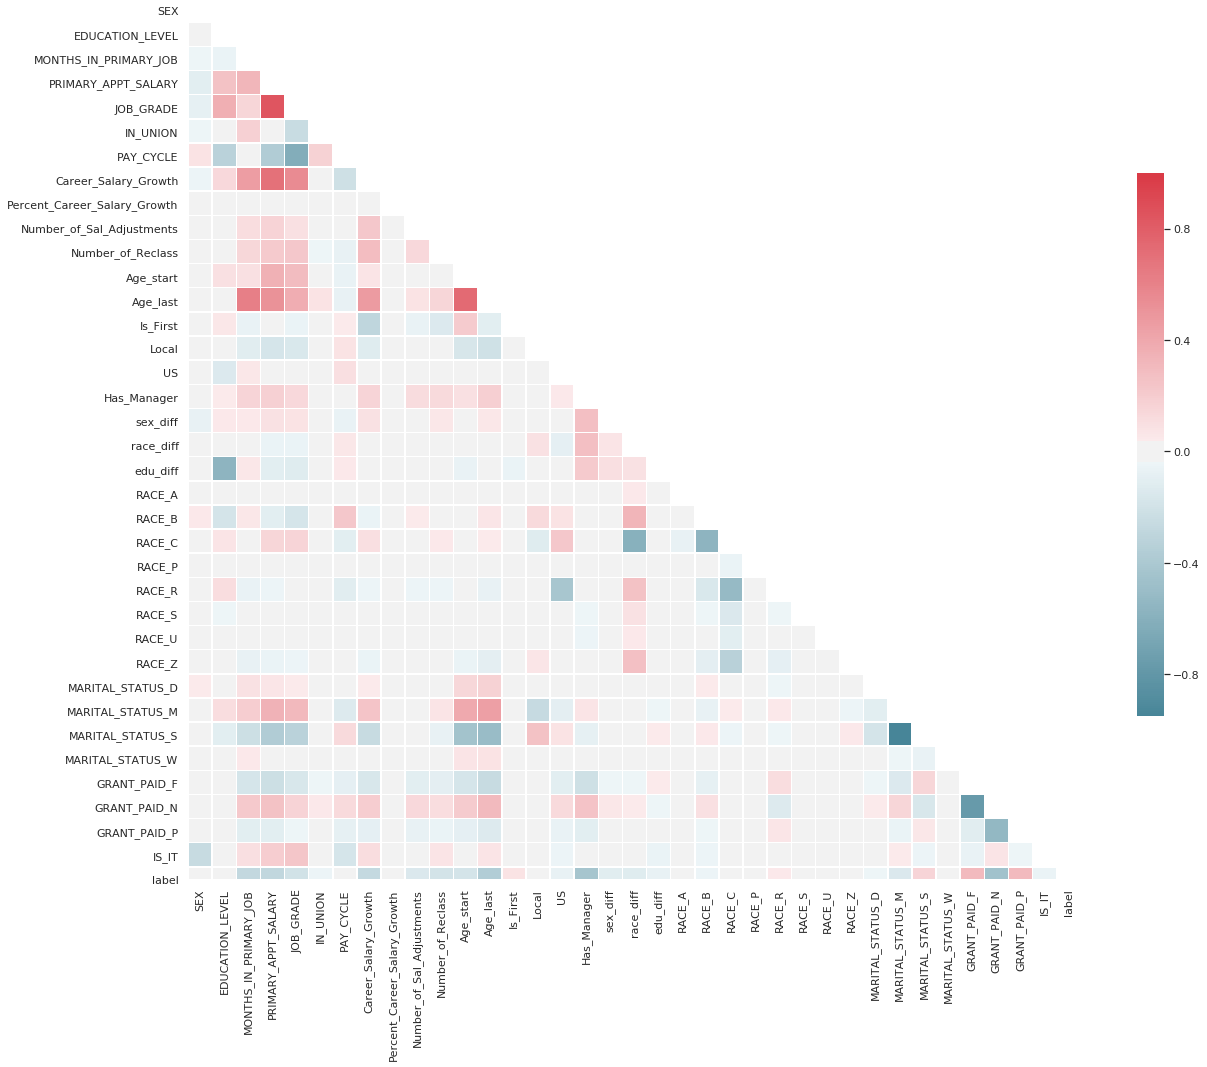

In [39]:
sns.set(style="white")

corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Standardize the data

In [0]:
# transform data into array
y = data[['label']].values.reshape(-1)
X = data.drop(columns='label')
X = X.values

# split into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train_standardized = scaler.transform(x_train)
x_test_standardized = scaler.transform(x_test)

## PCA

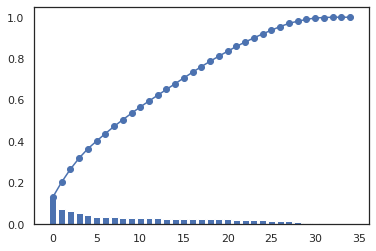

[0.131 0.203 0.266 0.319 0.364 0.402 0.438 0.472 0.505 0.536 0.567 0.595
 0.623 0.651 0.679 0.707 0.735 0.762 0.787 0.812 0.836 0.859 0.88  0.9
 0.919 0.938 0.955 0.97  0.981 0.989 0.996 0.998 1.    1.    1.   ]
31 components explained over 99% variance


In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components = x_train_standardized.shape[1]-1, whiten=True).fit(x_train_standardized) # 

ratio = pca.explained_variance_ratio_
cum_ratio = np.array([sum(ratio[0:i+1]) for i in range(len(ratio))])

plt.bar(list(range(len(ratio))),ratio)
plt.plot(cum_ratio,'-o')
plt.show()
print(np.round(cum_ratio,3))
t = 0.99
cut_off = np.where(cum_ratio>t)[0][0]+1
print('{} components explained over {}% variance'.format(cut_off, int(100*t)))

In [0]:
pca_final = PCA(n_components=cut_off).fit(x_train_standardized)
x_train_pca = pca.transform(x_train_standardized)
x_test_pca = pca.transform(x_test_standardized)

PCA not applicable for Random Forest. Only marginally better for the rest. 

## cross validation

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100,class_weight = "balanced")
lr = LogisticRegression(solver='lbfgs',max_iter=500)
svm = SVC(gamma='auto')
xg = XGBClassifier()

models = {}
models['Logistic Regression'] = lr
models['Random Forest'] = rfc
models['SVM'] = svm
models['XGBoost'] = xg

In [0]:
from sklearn.model_selection import KFold,cross_val_score
acc_results = []
auc_results = []

names = []
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)

i = 0
for name, model in models.items():
    kfold = KFold(n_splits=10)  # 10-fold cross-validation
    if name == 'Random Forest':
      x = x_train
    else:
      x = x_train_standardized

    cv_acc_results = cross_val_score(model, x, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = cross_val_score(model, x, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)

    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)]
    i += 1
print(df_results.sort_values(by=['ROC AUC Mean'], ascending=False))

             Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  Accuracy STD
3              XGBoost         89.61         1.07          83.05          1.07
1        Random Forest         89.45         0.99          83.57          1.21
0  Logistic Regression         85.87         1.15          79.91          1.38
2                  SVM         85.61         1.30          79.68          1.33


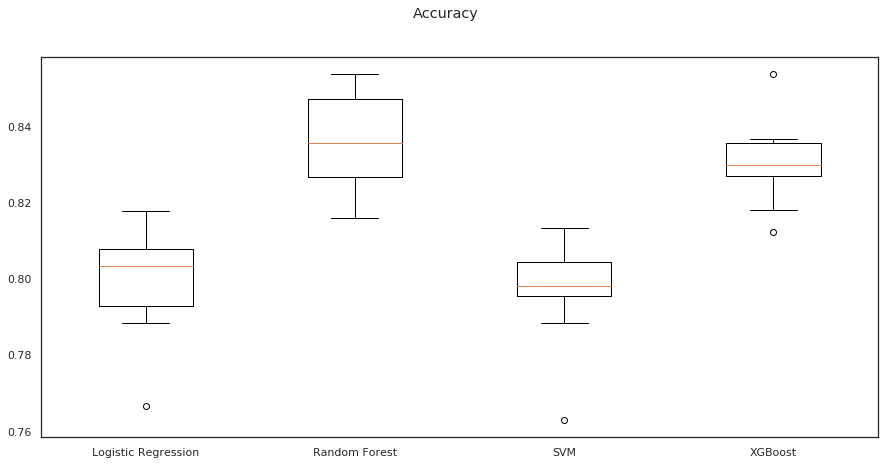

In [0]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()


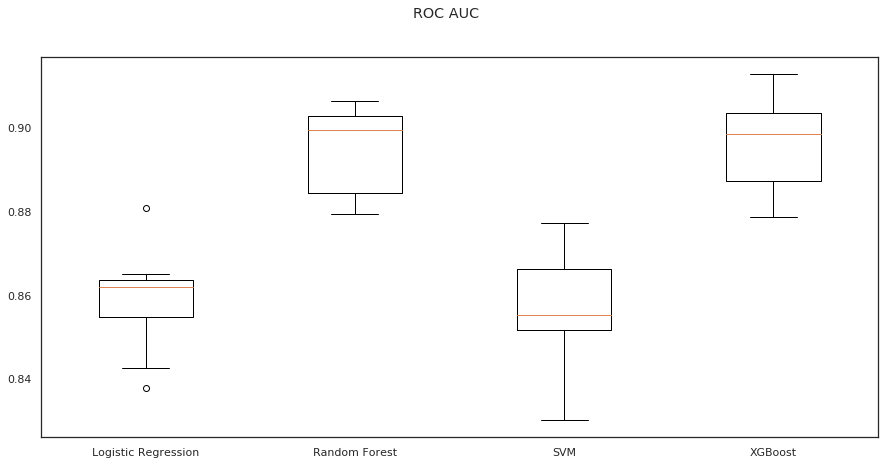

In [0]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('ROC AUC')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.show()

## Training accuracy

In [0]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

In [0]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(data.drop(columns='label'), data[['label']])
# print('Resampled dataset shape %s' % Counter(y_res))
def Plot_Metrics(y_test, y_pred):
  cnf_matrix = confusion_matrix(y_test, y_pred)  
  fig, ax = plt.subplots()
  sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu" ,fmt='d', linewidths=0.25)
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("roc_auc_score:",roc_auc_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))
  print("f1_score:",f1_score(y_test, y_pred))

### Logistic Regression

Accuracy: 0.7917015926236379
roc_auc_score: 0.7604288857374629
Precision: 0.8408759124087591
Recall: 0.5975103734439834
f1_score: 0.698605215281989


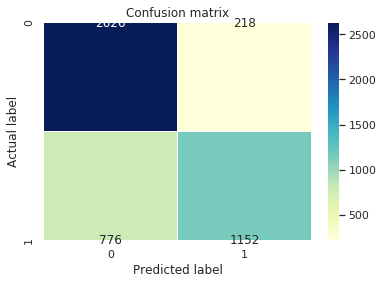

In [0]:
lr = LogisticRegression(solver='lbfgs',max_iter=500).fit(x_train_standardized, y_train)
y_pred = lr.predict(x_test_standardized)

Plot_Metrics(y_test, y_pred)

### Random Forest & Feature Importance

Accuracy: 0.8300502933780386
roc_auc_score: 0.8062168443720784
Precision: 0.8691341705221415
Recall: 0.6820539419087137
f1_score: 0.7643126997965708


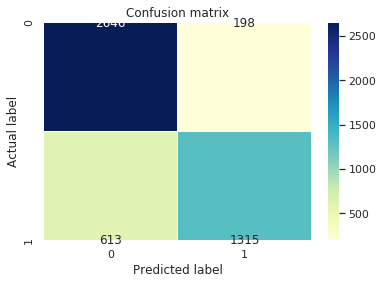

In [0]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)
Plot_Metrics(y_test, y_pred)


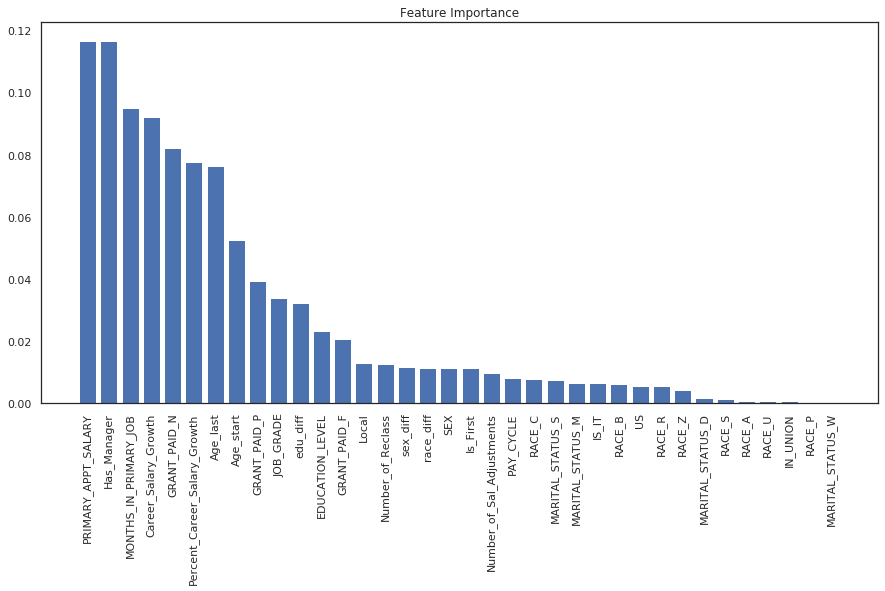

In [0]:
f = sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), data.drop(columns='label').columns), 
             reverse=True)
plt.figure(figsize=(15, 7))
plt.title("Feature Importance") 
plt.bar(range(len(f)), [x[0] for x in f]) 
plt.xticks(range(len(f)), [x[1] for x in f], rotation=90) 
plt.show() 

### Neural Nets

In [0]:
# see other notebook

### SVM

Accuracy: 0.7893964794635373
roc_auc_score: 0.7578978833484331
Precision: 0.8718342287029931
Recall: 0.5754812563323202
f1_score: 0.6933170582850167


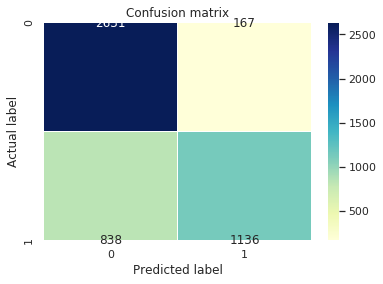

In [59]:
svm = SVC(gamma='auto')
svm.fit(x_train_standardized, y_train) 
y_pred = svm.predict(x_test_standardized)
Plot_Metrics(y_test, y_pred)

### XGBoost

In [0]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

Accuracy: 0.8227158424140821
roc_auc_score: 0.7937989857076994
Precision: 0.8869814020028612
Recall: 0.6431535269709544
f1_score: 0.745640408899579


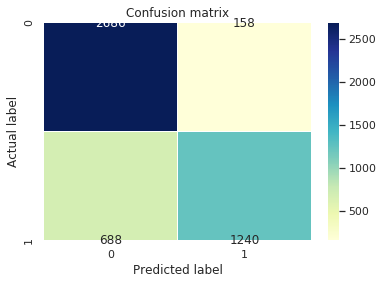

In [0]:
# from sklearn.metrics import mean_squared_error
# data_dmatrix = xgb.DMatrix(data=np.asarray(data.drop(columns='label')),label= np.asarray(data['label']))

xg = XGBClassifier()
xg.fit(x_train_standardized, y_train)
y_pred = xg.predict(x_test_standardized)

Plot_Metrics(y_test, y_pred)

## Fine-tuning

In [0]:
from sklearn.model_selection import GridSearchCV

### Random Forest

In [0]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [75, 100, 125, 150, 175, 200],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4]}

grid = GridSearchCV(rf, param_grid=param_grid, scoring='roc_auc', cv=10)

g = grid.fit(x_train, y_train)


In [92]:
rf_opt = g.best_estimator_
print("best params: " + str(g.best_estimator_))
print("best params: " + str(g.best_params_))
print('best score:', g.best_score_)

best params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
best params: {'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}
best score: 0.8949896611649929


Accuracy: 0.8292120704107293
roc_auc_score: 0.8084105161234721
Precision: 0.8721901091843288
Recall: 0.6879432624113475
f1_score: 0.7691871990937411


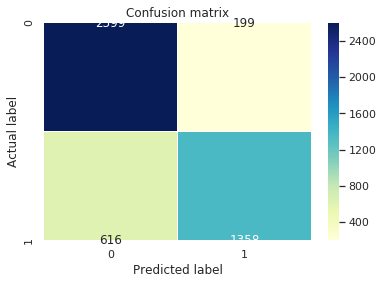

In [93]:
y_pred = rf_opt.predict(x_test)
Plot_Metrics(y_test,y_pred)

In [94]:
 probs = rf_opt.predict_proba(x_test) 
# only keep probabilities associated with the employee leaving
a = roc_auc_score(y_test, probs[:, 1]) 
print('AUC score: {}'.format(round(a,3)))

AUC score: 0.893


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f055fe67e80>]],
      dtype=object)

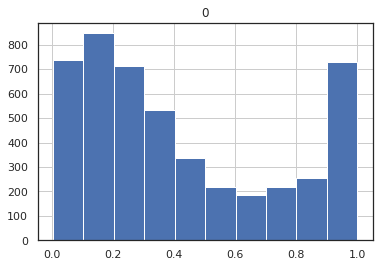

In [66]:
pd.DataFrame(probs[:,1]).hist()

### Logistic Regression

In [0]:
param_grid = {'C': np.arange(1e-03, 2, 0.01)} # hyper-parameter list to fine-tune
grid = GridSearchCV(LogisticRegression(solver='lbfgs',max_iter=500),
                      iid=True,
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

l = grid.fit(x_train_standardized, y_train)

In [56]:
lr_opt = l.best_estimator_
results = l.cv_results_

print("best params: " + str(l.best_estimator_))
print("best params: " + str(l.best_params_))
print('best score:', l.best_score_)

best params: LogisticRegression(C=1.8109999999999997, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
best params: {'C': 1.8109999999999997}
best score: 0.8564028470495619


Accuracy: 0.7917015926236379
roc_auc_score: 0.7641900097985753
Precision: 0.8480113636363636
Recall: 0.6048632218844985
f1_score: 0.7060910703725607


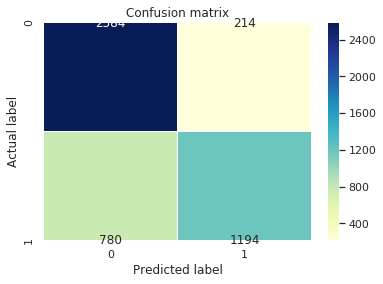

In [57]:
# lr_opt.fit(x_train_standardized, y_train)
y_pred = lr_opt.predict(x_test_standardized)
Plot_Metrics(y_test,y_pred)

In [58]:
lr_opt.fit(x_train_standardized, y_train) 
probs = lr_opt.predict_proba(x_test_standardized) 
# only keep probabilities associated with the employee leaving
abs = roc_auc_score(y_test, probs[:, 1]) 
print('AUC score: {}'.format(round(a,3)))

AUC score: 0.853
